# Product Recommendation Project
---

## BUSINESS PROBLEM
---
Providing product recommendations to users based on their shopping basket analysis using Association Rule Based Recommendation Systems.

## DATASET STORY
---

This dataset, called 'Online Retail,' tracks the sales of a UK-based online store from December 1, 2009, to December 9, 2011.
This company's product catalog includes gift items.

## FEATURES
---

- **InvoiceNo:** Invoice Number - If this code starts with 'C', it means the transaction was canceled.
- **StockCode:** Product Code - A unique number for each product.
- **Description:** Product Name - Quantity - Quantity of the product
- **Quantity:** Quantity of the product - Indicates how many of the products were sold in the invoices.
- **InvoiceDate:** Invoice Date
- **UnitPrice:** Unit Price of the Invoice (in British Pounds)
- **CustomerID:** Unique Customer Number
- **Country:** Country Name

## STEPS
---
### Step 1: Explorative Data Analysis
### Step 2: Data Preprocessing
### Step 3: Preparing ARL Data Structure
### Step 4: Association Rule Learning
### Step 5: Providing Product Recommendations to Users in the Basket Stage

---

### *Libraries and Settings*
---

In [123]:
# !pip install mlxtend 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend. frequent_patterns import apriori, association_rules
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

---
# Explorative Data Analysis
---

In [124]:
online_retail = pd.read_excel("/kaggle/input/online-retail-ii-for-arl/online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [125]:
df = online_retail.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [126]:
df.describe().T
df["Country"].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8558
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [127]:
df.shape

(541910, 8)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [129]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

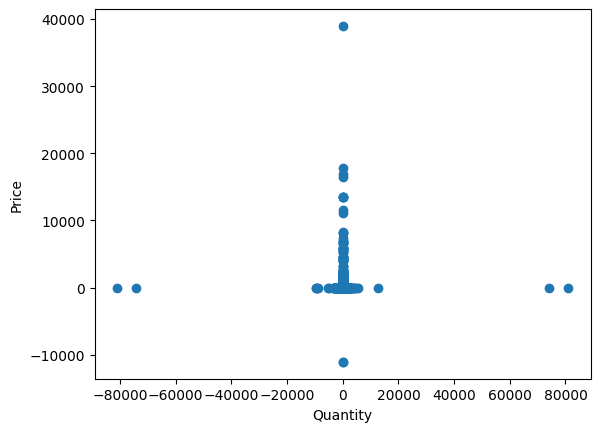

In [130]:
plt.scatter(df["Quantity"], df["Price"])
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.show();

### Comments:
- As we see there are minus values in 'Quantity' and 'Price' (most prob caused by 'C' coded products / cancelled products) which they are expected to be min 0.
- Also, we observe that the range between 75% and max values are extremely high in compare to 50% and 75% and it is required to be corrected.
- There are some missing values in 'Description' and 'Customer ID'

---
# Data Preprocessing
---

We define a couple of functions to prepare our data for ARL.

In [131]:
def outliers_thresholds_finder(dataframe, col_name, lower_threshold= 0.25, upper_threshold=0.75):
    q1 = dataframe[col_name].quantile(lower_threshold)
    q3 = dataframe[col_name].quantile(upper_threshold)
    IQR = q3 - q1
    low_limit = q1 - 1.5 * IQR
    up_limit = q3 + 1.5 * IQR
    return low_limit, up_limit

def winsorize(dataframe, col_name, lower_threshold= 0.25, upper_threshold=0.75):
    low_limit, up_limit = outliers_thresholds_finder(dataframe, col_name, lower_threshold, upper_threshold)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit
    return dataframe

def online_retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe[dataframe["Invoice"].apply(lambda x: "C" not in str(x))]
    dataframe = dataframe[dataframe["Price"] > 0]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = winsorize(dataframe, "Price", 0.01, 0.99)
    dataframe = winsorize(dataframe, "Quantity", 0.01, 0.99)
    return dataframe

In [132]:
df = online_retail_data_prep(df)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397885.0,11.83077,1.0,2.0,6.0,12.0,298.5,25.523052
InvoiceDate,397885,2011-07-10 23:41:56.419316992,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397885.0,2.893492,0.001,1.25,1.95,3.75,37.06,3.227175
Customer ID,397885.0,15294.416882,12346.0,13969.0,15159.0,16795.0,18287.0,1713.144421


In [133]:
df.shape

(397885, 8)

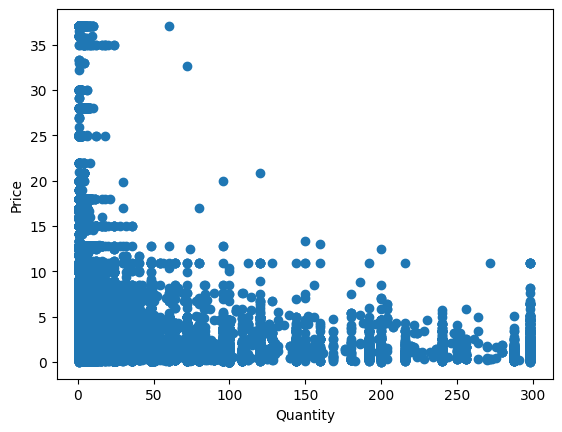

In [134]:
plt.scatter(df["Quantity"], df["Price"])
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.show();

### Comments:
- As dataset is big enough, all missing values are dropped.
- Invoices starting with 'C'(cancelled) are dropped.
- Observations with minus values in 'Price' and 'Quantity' are deleted.
- Outliers are winsorized using 0.01 and 0.99 thresholds.

---
# Preparing ARL Data Structure (Invoice-Product Matrix)
---

To create an Invoice-Product matrix for Association Rule Learning (ARL), where invoices are represented in rows and products in columns, we need to group them by summing the quantities for each invoice while considering each product (listed under 'Description').

**Note:** For demonstration purposes, 'Description' / Product names are used in columns. However, in regular circumstances, it is advisable to utilize product IDs or similar numerical values to represent products, particularly when considering CPU performance.

In [135]:
df_groupby = df.groupby(["Invoice","Description"]).agg({"Quantity":"sum"})
df_groupby

Quantity
Invoice Description                                  
536365  CREAM CUPID HEARTS COAT HANGER            8.0
        GLASS STAR FROSTED T-LIGHT HOLDER         6.0
        KNITTED UNION FLAG HOT WATER BOTTLE       6.0
        RED WOOLLY HOTTIE WHITE HEART.            6.0
        SET 7 BABUSHKA NESTING BOXES              2.0
...                                               ...
581587  PACK OF 20 SPACEBOY NAPKINS              12.0
        PLASTERS IN TIN CIRCUS PARADE            12.0
        PLASTERS IN TIN STRONGMAN                12.0
        POSTAGE                                   1.0
        SPACEBOY LUNCH BOX                       12.0

[387739 rows x 1 columns]

In [136]:
df_arl = df_groupby.reset_index().pivot_table("Quantity","Invoice","Description")
df_arl

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
536365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.0,NaN,NaN,NaN,24.0,NaN,NaN


Now, we need to convert each quantity (frequency) in the Invoice-Product Matrix to a binary form.

In [137]:
df_arl = df_arl.applymap(lambda x: 1 if x > 0 else 0)
df_arl = df_arl.astype("int8")
df_arl

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


---
# Association Rule Learning
---

Let's say we want to apply Association Rule Learning for Germany.

In [138]:
country = "Germany"
df_at = df[df["Country"] == country]

df_at = df_at.groupby(["Invoice","StockCode"]).agg({"Quantity":"sum"}) \
              .reset_index().pivot_table("Quantity","Invoice","StockCode") \
              .applymap(lambda x: 1 if x > 0 else 0)

# for using the memory efficiently
from scipy.sparse import csr_matrix
df_at = df_at.astype("int8")
df_arl = csr_matrix(df_at.values)
df_arl = pd.DataFrame.sparse.from_spmatrix(df_arl, columns=df_at.columns)
df_arl.columns = [str(i) for i in df_arl.columns]
              
df_arl.head()

,10002,10125,10135,11001,15034,15036,15039,16008,16011,16014,...,90161B,90161C,90161D,90201A,90201B,90201C,90201D,90202D,M,POST
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


We apply for our case the threshold of 0.01 for support.

In [139]:
freq_itemsets = apriori(df_arl, min_support=0.01,use_colnames=True)
freq_itemsets

,support,itemsets
0,0.013129,(10125)
1,0.019694,(15036)
2,0.010941,(16016)
3,0.015317,(16045)
4,0.010941,(16235)
...,...,...
6950,0.010941,"(POST, 22326, 22554, 22556, 22328, 22555)"
6951,0.010941,"(POST, 21670, 21673, 21672, 21669, 21668, 21671)"
6952,0.010941,"(POST, 22326, 21670, 21673, 21672, 21668, 21671)"
6953,0.010941,"(POST, 22423, 21670, 21673, 21672, 21668, 21671)"


In [192]:
rules = association_rules(freq_itemsets, 
                          metric="support", 
                          min_threshold=0.01)

rules.sort_values(["lift","confidence","support"], ascending=False).head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
24744,"(21987, 21989)","(21988, 21086)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
24746,"(21987, 21988)","(21989, 21086)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
24747,"(21989, 21086)","(21987, 21988)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
24749,"(21988, 21086)","(21987, 21989)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
39025,"(21987, 21094, 21988)","(21989, 21086)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
39028,"(21987, 21989, 21094)","(21988, 21086)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
39032,"(21988, 21086, 21094)","(21987, 21989)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
39034,"(21989, 21086, 21094)","(21987, 21988)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
39035,"(21987, 21988)","(21989, 21086, 21094)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000
39037,"(21987, 21989)","(21988, 21086, 21094)",0.010941,0.010941,0.010941,1.0,91.400000,0.010821,inf,1.000000


---
# Providing Product Recommendations to Users in the Basket Stage
---

Let's define some functions to find relevant products based on a given Stock Code.

In [231]:
def get_product_name(StockCode):
    df_temp = df.copy()
    df_temp["StockCode"] = df_temp["StockCode"].astype("str")
    p_name = df_temp[df_temp["StockCode"] == str(StockCode)]["Description"].iloc[0]
    return p_name

def find_recommended_products(StockCodes):
    codes = list()
    for code in StockCodes:
        codes.append(str(code))
    
    codes = frozenset(codes)

    rules_sorted = rules.sort_values(["lift","confidence","support"], ascending=False)
    
    result_list = list()
    for inx, product in enumerate(rules_sorted["antecedents"]):
        if product == codes:
            result_list.append(list(rules_sorted.iloc[inx]["consequents"]))
    
    return result_list

Let's get recommendations for selected product or product set in our basket.

In [236]:
products_in_basket = [21987, 21094, 21988]
rec_list = find_recommended_products(products_in_basket)
rec_list

[['21989', '21086'], ['21989'], ['21086']]

As we have found recommendations for selected product set, let's see what are these recommedations.

In [237]:
# Names of products in the basket
print("Products in basket:")
for no, code in enumerate(products_in_basket,1):
    print("->", get_product_name(code))

for no, codes in enumerate(rec_list,1):
    print("\n")
    print(no, ". Recommendation Set:")
    for code in codes:
        print("->", get_product_name(code))

Products in basket:
-> PACK OF 6 SKULL PAPER CUPS
-> SET/6 RED SPOTTY PAPER PLATES
-> PACK OF 6 SKULL PAPER PLATES


1 . Recommendation Set:
-> PACK OF 20 SKULL PAPER NAPKINS
-> SET/6 RED SPOTTY PAPER CUPS


2 . Recommendation Set:
-> PACK OF 20 SKULL PAPER NAPKINS


3 . Recommendation Set:
-> SET/6 RED SPOTTY PAPER CUPS


## I hope you found the analysis insightful and informative!

## Your feedback is greatly appreciated, and I welcome any suggestions for improvement. Feel free to reach out with any questions or comments.